## Problem 3:

#### (a)

In [1]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

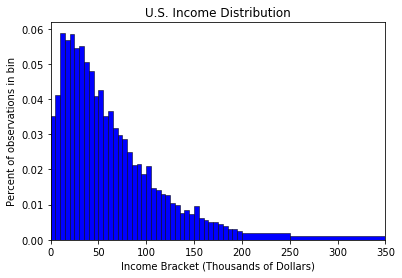

In [157]:
incs = np.loadtxt('usincmoms.txt', delimiter='\t')
incs[:,1] = incs[:,1] / 1000
incs[:,[1,0]] = incs[:,[0,1]]

num_bins = 42
rects = plt.bar(incs[:,0], incs[:,1], width=5, color='b',
                edgecolor='black', linewidth=0.5,
                align='center')

rects[40].set_width(50)
rects[40].set_x(200)
rects[40].set_height(rects[40].get_height() / 10)
rects[41].set_width(100)
rects[41].set_x(250)
rects[41].set_height(rects[41].get_height() / 20)
plt.xlabel('Income Bracket (Thousands of Dollars)')
plt.ylabel('Percent of observations in bin')
plt.xlim([0, 350])
plt.title("U.S. Income Distribution")
plt.show()

#### (b)

In [80]:
def lognorm_pdf(x, mu, sigma):
    return sts.lognorm.pdf(x, 1, mu, sigma)

def data_moments(xvals):
    return xvals

def model_moments(bracks, mu, sigma):
    moms = np.zeros_like(bracks)
    xfx = lambda x: lognorm_pdf(x, mu, sigma)
    for i in range(40):
        moms[i] = intgr.quad(xfx, bracks[i] - 2.5, 
                             bracks[i] + 2.5)[0]
    moms[40] = intgr.quad(xfx, bracks[40]-25, bracks[40]+25)[0]
    moms[41] = intgr.quad(xfx, bracks[41]-50, bracks[41]+50)[0]

    return moms

def err_vec(xvals, bracks, mu, sigma):
    moms_data = data_moments(xvals)
    moms_model = model_moments(bracks, mu, sigma)
    
    err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, W, bracks = args
    err = err_vec(xvals, bracks, mu, sigma)
    crit_val = (err.T @ W) @ err
    
    return crit_val

def weight_arr(xvals):
    return np.diag(xvals)

xvals = incs[:,1]
bracks = incs[:,0]
mu_init = incs[:,0] @ incs[:,1]
sig_init = 30
params_init = np.array([mu_init, sig_init])
W_hat = weight_arr(xvals)
gmm_args = (xvals, W_hat, bracks)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B',
                        bounds=((1e-10,None),(1e-10,None)))

mu_GMM1, sig_GMM1 = results.x
crit_GMM1 = criterion(np.array([mu_GMM1, sig_GMM1]), 
                      xvals, W_hat, bracks)
print('Converged?', results.success)
print('mu_GMM1=', mu_GMM1, '\nsig_GMM1=', sig_GMM1)
print('Criterion value=', crit_GMM1)

Converged? True
mu_GMM1= 1e-10 
sig_GMM1= 48.9668569092
Criterion value= 0.0360113341677


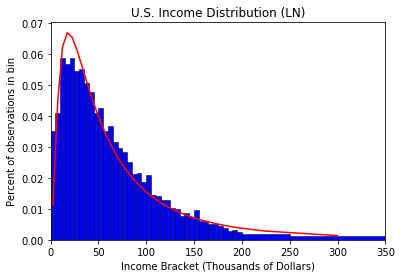

In [159]:
num_bins = 42
ind = np.arange(0, num_bins * 5, 5)
rects = plt.bar(incs[:,0], incs[:,1], width=5, color='b',
                edgecolor='black', linewidth=0.5,
                align='center')

rects[40].set_width(50)
rects[40].set_x(200)
rects[40].set_height(rects[40].get_height() / 10)
rects[41].set_width(100)
rects[41].set_x(250)
rects[41].set_height(rects[41].get_height() / 20)
plt.xlabel('Income Bracket (Thousands of Dollars)')
plt.ylabel('Percent of observations in bin')
plt.xlim([0, 350])
plt.title("U.S. Income Distribution (LN)")

dist_pts = np.linspace(0, 350, 500)
model_moms = model_moments(bracks, mu_GMM1, sig_GMM1)
model_moms[40] /= 10
model_moms[41] /= 20

plt.plot(bracks, model_moms, linewidth=1.5, color='red')
plt.show()

#### (c)

In [62]:
import math

def gamma_pdf(xvals, alpha, beta):
    return (((xvals ** (alpha - 1)) * np.exp((-1)* xvals / beta))/
            ((beta ** alpha) * math.gamma(alpha)))
    

def data_moments_ga(xvals):
    return xvals

def model_moments_ga(bracks, alpha, beta):
    moms = np.zeros_like(bracks)
    xfx = lambda x: gamma_pdf(x, alpha, beta)
    for i in range(40):
        moms[i] = intgr.quad(xfx, bracks[i] - 2.5, 
                             bracks[i] + 2.5)[0]
    moms[40] = intgr.quad(xfx, bracks[40]-25, bracks[40]+25)[0]
    moms[41] = intgr.quad(xfx, bracks[41]-50, bracks[41]+50)[0]
    return moms

def err_vec_ga(xvals, bracks, alpha, beta):
    moms_data = data_moments_ga(xvals)
    moms_model = model_moments_ga(bracks, alpha, beta)
    
    err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion_ga(params, *args):
    alpha, beta = params
    xvals, W, bracks = args
    err = err_vec_ga(xvals, bracks, alpha, beta)
    crit_val = (err.T @ W) @ err
    
    return crit_val

def weight_arr(xvals):
    return np.diag(xvals)

xvals = incs[:,1]
bracks = incs[:,0]
alpha_init = 1
beta_init = 50
params_init_ga = np.array([alpha_init, beta_init])
W_hat = weight_arr(xvals)
gmm_args = (xvals, W_hat, bracks)
results = opt.minimize(criterion_ga, params_init_ga, args=(gmm_args),
                       method='L-BFGS-B',
                       bounds=((1e-10,None),(1e-10,None)))

alpha_GMM, beta_GMM = results.x
crit_GMM1 = criterion_ga(np.array([alpha_GMM, beta_GMM]), 
                         xvals, W_hat, bracks)
print("Converged?", results.success)
print('alpha_GMM=', alpha_GMM, '\nbeta_GMM=', beta_GMM)
print('Criterion value=', crit_GMM1)

Converged? True
alpha_GMM= 1.36708708401 
beta_GMM= 48.0610095167
Criterion value= 0.0140849196048


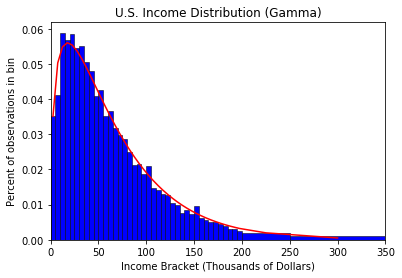

In [162]:
num_bins = 42
ind = np.arange(0, num_bins * 5, 5)
rects = plt.bar(incs[:,0], incs[:,1], width=5, color='b',
                edgecolor='black', linewidth=0.5,
                align='center')

rects[40].set_width(50)
rects[40].set_x(200)
rects[40].set_height(rects[40].get_height() / 10)
rects[41].set_width(100)
rects[41].set_x(250)
rects[41].set_height(rects[41].get_height() / 20)
plt.xlabel('Income Bracket (Thousands of Dollars)')
plt.ylabel('Percent of observations in bin')
plt.xlim([0, 350])
plt.title("U.S. Income Distribution (Gamma)")


model_moms_ga = model_moments_ga(bracks, alpha_GMM, beta_GMM)
model_moms_ga[40] /= 10
model_moms_ga[41] /= 20
plt.plot(bracks, model_moms_ga, linewidth=1.5, color='r')
plt.show()

#### (d)

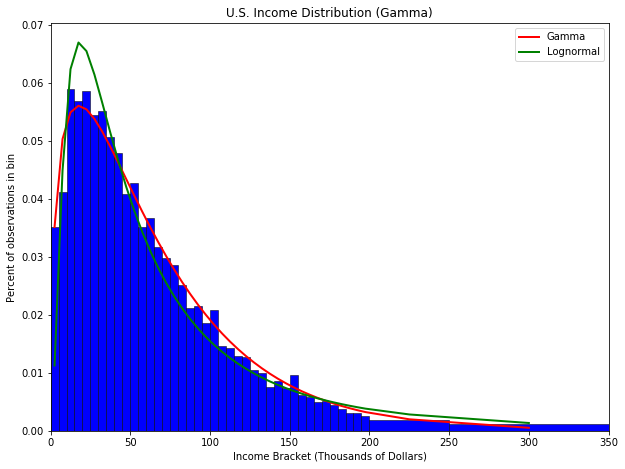

In [163]:
num_bins = 42
ind = np.arange(0, num_bins * 5, 5)
plt.figure(figsize=(10,7.5))
rects = plt.bar(incs[:,0], incs[:,1], width=5, color='b',
                edgecolor='black', linewidth=0.5,
                align='center')


rects[40].set_width(50)
rects[40].set_x(200)
rects[40].set_height(rects[40].get_height() / 10)
rects[41].set_width(100)
rects[41].set_x(250)
rects[41].set_height(rects[41].get_height() / 20)
plt.xlabel('Income Bracket (Thousands of Dollars)')
plt.ylabel('Percent of observations in bin')
plt.xlim([0, 350])
plt.title("U.S. Income Distribution (Gamma)")


plt.plot(bracks, model_moms_ga, linewidth=2, color='r', label="Gamma")
plt.plot(bracks, model_moms, linewidth=2, color='g', label="Lognormal")
plt.legend()
plt.show()

Visually, the gamma specification seems to fit the distribution of incomes better than the lognormal specification. This is confirmed by looking at the criterion values for each function.

#### (e)

In [176]:
W_eye = np.eye(xvals.shape[0])
eye_args = (xvals, W_eye, bracks)
results_eye = opt.minimize(criterion_ga, params_init_ga, args=(eye_args),
                       method='L-BFGS-B',
                       bounds=((1e-10,None),(1e-10,None)))

alpha_eye, beta_eye = results_eye.x
crit_eye = criterion_ga(np.array([alpha_eye, beta_eye]), 
                         xvals, W_hat, bracks)
print("Converged?", results_eye.success)
print('alpha_eye=', alpha_eye, '\nbeta_eye=', beta_eye)
print('Criterion value=', crit_eye)

errs_eye = err_vec_ga(xvals, bracks, alpha_eye, beta_eye)
errs_eye = np.reshape(errs_eye, (42, 1))
VCV2 = (errs_eye @ errs_eye.T) / 42
W_twostep = lin.pinv(VCV2)

twostep_args = (xvals, W_twostep, bracks)
alpha_init_ts = 0.5
beta_init_ts = 50
params_init_twostep = np.array([alpha_init_ts, beta_init_ts])
results_twostep = opt.minimize(criterion_ga, params_init_twostep, 
                               args=(twostep_args), method='L-BFGS-B',
                               bounds=((1e-10,None),(1e-10,None)))

alpha_twostep, beta_twostep = results_twostep.x
crit_twostep = criterion_ga(np.array([alpha_twostep, beta_twostep]), 
                         xvals, W_hat, bracks)
print("\nConverged?", results_twostep.success)
print('alpha_twostep=', alpha_twostep, '\nbeta_twostep=', beta_twostep)
print('Criterion value=', crit_twostep)
print(results_twostep)


Converged? True
alpha_eye= 1.37436086095 
beta_eye= 46.2114840925
Criterion value= 0.738892926279

Converged? True
alpha_twostep= 2.8260611508 
beta_twostep= 50.5006489724
Criterion value= 149.488046454
      fun: 9.7618496292534575e-15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.07568166e-06,   4.18303859e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 42
      nit: 5
   status: 0
  success: True
        x: array([  2.82606115,  50.50064897])


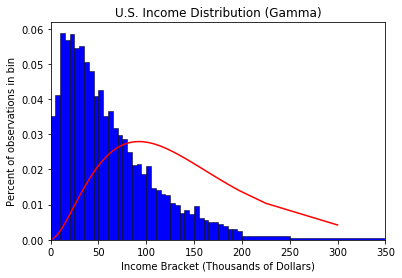

In [178]:
num_bins = 42
ind = np.arange(0, num_bins * 5, 5)
rects = plt.bar(incs[:,0], incs[:,1], width=5, color='b',
                edgecolor='black', linewidth=0.5,
                align='center')

rects[40].set_width(50)
rects[40].set_x(200)
rects[40].set_height(rects[40].get_height() / 20)
rects[41].set_width(100)
rects[41].set_x(250)
rects[41].set_height(rects[41].get_height() / 40)
plt.xlabel('Income Bracket (Thousands of Dollars)')
plt.ylabel('Percent of observations in bin')
plt.xlim([0, 350])
plt.title("U.S. Income Distribution (Gamma)")


model_moms_ts = model_moments_ga(bracks, alpha_twostep, beta_twostep)
model_moms_ts[40] /= 10
model_moms_ts[41] /= 20
plt.plot(bracks, model_moms_ts, linewidth=1.5, color='r')
plt.show()